# Outlier Detection

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import typing

In [2]:
anio = 2009

In [3]:
data = pd.read_csv(f'/home/jovyan/work/dags/data/raw/{anio}_sample.csv')

In [4]:
# This wrapper will apply any sklearn transform you pass into it to a group.
class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation

    def __call__(self, df):
        transformed = self.transformation.fit_transform(df.values)
        return pd.DataFrame(transformed, columns=df.columns, index=df.index)

In [5]:
grouped = data.groupby(['ORIGIN','FL_DATE']).agg({'OP_CARRIER_FL_NUM': 'count', 'DEP_DELAY': 'mean'})

df_rescaled = (
    grouped.groupby("ORIGIN")
    .apply(SklearnWrapper(StandardScaler()))
    .rename(columns = {'DEP_DELAY': 'DEL_SCALED'})
    .drop(columns=['OP_CARRIER_FL_NUM'])
)
df_rescaled = (
    grouped.join(df_rescaled)
    .assign(OUTLIER=(abs(df_rescaled.DEL_SCALED)>=3).astype(int))
    .rename(columns= {'OP_CARRIER_FL_NUM': 'NUM_FLIGHTS'})
)

In [6]:
df_rescaled.head()

NUM_FLIGHTS  DEP_DELAY  DEL_SCALED  OUTLIER
ORIGIN FL_DATE                                                
ABE    2009-01-01           12  -2.916667   -0.816856        0
       2009-01-02           14   2.357143   -0.385754        0
       2009-01-03            9  25.500000    1.506036        0
       2009-01-04           11   9.636364    0.209279        0
       2009-01-05           13   4.153846   -0.238884        0

In [7]:
df_rescaled.OUTLIER.sum()

220

# Graficos

In [7]:
airport = 'ABI'

In [13]:
df_res = df_rescaled.reset_index()

In [9]:
df_rescaled[df_rescaled.OUTLIER ==1].head()

,,NUM_FLIGHTS,DEP_DELAY,DEL_SCALED,OUTLIER
ORIGIN,FL_DATE,,,,
ABI,2009-01-28,7,190.200000,3.735343,1
ABQ,2009-01-05,107,24.570093,3.212889,1
ABY,2009-01-20,3,28.666667,3.380956,1
ACT,2009-01-28,4,156.750000,4.560705,1
ADQ,2009-01-16,2,112.000000,4.465529,1


In [10]:
df_res.head()

,ORIGIN,FL_DATE,NUM_FLIGHTS,DEP_DELAY,DEL_SCALED,OUTLIER
0,ABE,2009-01-01,12,-2.916667,-0.816856,0
1,ABE,2009-01-02,14,2.357143,-0.385754,0
2,ABE,2009-01-03,9,25.500000,1.506036,0
3,ABE,2009-01-04,11,9.636364,0.209279,0
4,ABE,2009-01-05,13,4.153846,-0.238884,0


In [15]:
df_res['ORIGIN'].unique()

array(['ABE', 'ABI', 'ABQ', 'ABY', 'ACT', 'ACV', 'ADK', 'ADQ', 'AEX',
       'AGS', 'ALB', 'ALO', 'AMA', 'ANC', 'ASE', 'ATL', 'ATW', 'AUS',
       'AVL', 'AVP', 'AZO', 'BDL', 'BET', 'BFL', 'BGM', 'BGR', 'BHM',
       'BIL', 'BIS', 'BMI', 'BNA', 'BOI', 'BOS', 'BQK', 'BQN', 'BRO',
       'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE',
       'CAK', 'CDC', 'CDV', 'CEC', 'CHA', 'CHO', 'CHS', 'CIC', 'CID',
       'CLD', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'COD', 'COS',
       'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'DAB', 'DAL', 'DAY',
       'DBQ', 'DCA', 'DEN', 'DFW', 'DHN', 'DLH', 'DRO', 'DSM', 'DTW',
       'EGE', 'EKO', 'ELM', 'ELP', 'ERI', 'EUG', 'EVV', 'EWN', 'EWR',
       'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FLO',
       'FNT', 'FSD', 'FSM', 'FWA', 'GCC', 'GEG', 'GFK', 'GGG', 'GJT',
       'GNV', 'GPT', 'GRB', 'GRK', 'GRR', 'GSO', 'GSP', 'GTF', 'GTR',
       'GUC', 'HDN', 'HLN', 'HNL', 'HOU', 'HPN', 'HRL', 'HSV', 'HTS',
       'IAD', 'IAH',

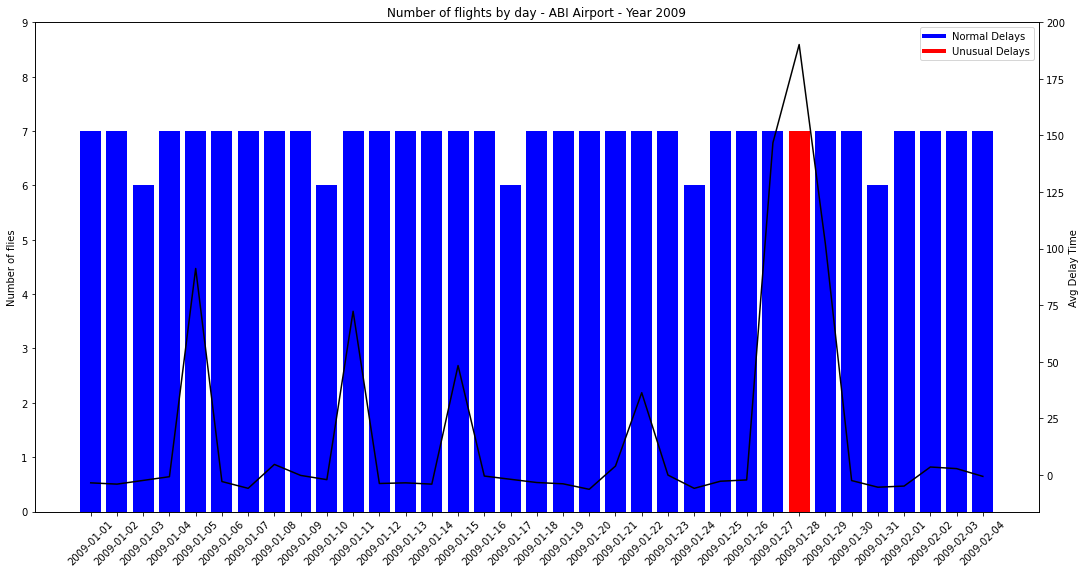

In [100]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()

ax.yaxis.tick_left()
ax2.yaxis.tick_right()

ax.bar(df_rescaled[df_rescaled.index.isin([airport], level=0)].reset_index().FL_DATE, 
        df_rescaled[df_rescaled.index.isin([airport], level=0)].NUM_FLIGHTS, 
        color= list(map(lambda x: 'blue' if x <= 0 else 'red', df_rescaled[df_rescaled.index.isin([airport], level=0)].OUTLIER)) )

ax.set_ylabel('Number of flies')

ax2.plot(ax.get_xticks(), 
        df_rescaled[df_rescaled.index.isin([airport], level=0)].DEP_DELAY, color='black')
ax2.set_ylabel('Avg Delay Time')

plt.title(f'Number of flights by day - {airport} Airport - Year {anio}')

ax.set_ylim(top= (df_rescaled[df_rescaled.index.isin([airport], level=0)].NUM_FLIGHTS.max() + 2))
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_lines, ['Normal Delays', 'Unusual Delays'])


plt.setp( ax.xaxis.get_majorticklabels(), rotation=45)

fig.savefig(f'/home/jovyan/work/dags/data/plt/{anio}-{airport}.jpg', transparent=False, dpi=80, bbox_inches="tight")
plt.show()

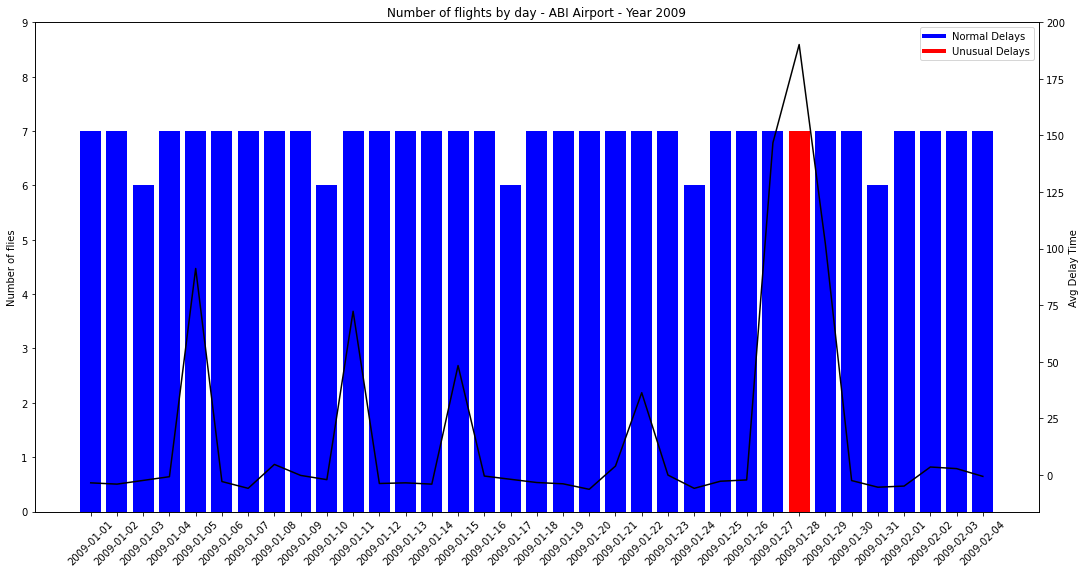

In [17]:
df = df_res[df_res['ORIGIN']== airport]

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()

ax.yaxis.tick_left()
ax2.yaxis.tick_right()

ax.bar(df.FL_DATE, df.NUM_FLIGHTS, 
        color= list(map(lambda x: 'blue' if x <= 0 else 'red', df.OUTLIER)) )

ax.set_ylabel('Number of flies')

ax2.plot(ax.get_xticks(), df.DEP_DELAY, color='black')
ax2.set_ylabel('Avg Delay Time')

plt.title(f'Number of flights by day - {airport} Airport - Year {anio}')

ax.set_ylim(top= (df.NUM_FLIGHTS.max() + 2))
custom_lines = [Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_lines, ['Normal Delays', 'Unusual Delays'])


plt.setp( ax.xaxis.get_majorticklabels(), rotation=45)

fig.savefig(f'/home/jovyan/work/dags/data/plt/{anio}-{airport}.jpg', transparent=False, dpi=80, bbox_inches="tight")
plt.show()

# Save data

In [10]:
class DepDelay:
    """Departure delay data model."""
    def __init__(self, origin, date, num_flights, dep_delay, del_scaled, outlier):
        self.origin = origin
        self.date = date
        self.num_flights = num_flights
        self.dep_delay = dep_delay
        self.del_scaled = del_scaled
        self.outlier = outlier

    def __repr__(self):
        return f"<DepDelay(origin='{self.origin}', date='{self.date}', ...)>"

    def __str__(self):
        return f"{self.origin} {self.date}: ${self.num_flights}"

    def get_keys(self):
        return {'origin': self.origin, 'date': self.date}

In [13]:
df_rescaled.reset_index().head().to_dict('records')

[{'ORIGIN': 'ABE',
  'FL_DATE': '2009-01-01',
  'NUM_FLIGHTS': 12,
  'DEP_DELAY': -2.9166666666666665,
  'DEL_SCALED': -0.8168563638859062,
  'OUTLIER': 0},
 {'ORIGIN': 'ABE',
  'FL_DATE': '2009-01-02',
  'NUM_FLIGHTS': 14,
  'DEP_DELAY': 2.357142857142857,
  'DEL_SCALED': -0.3857540353754194,
  'OUTLIER': 0},
 {'ORIGIN': 'ABE',
  'FL_DATE': '2009-01-03',
  'NUM_FLIGHTS': 9,
  'DEP_DELAY': 25.5,
  'DEL_SCALED': 1.5060358667112315,
  'OUTLIER': 0},
 {'ORIGIN': 'ABE',
  'FL_DATE': '2009-01-04',
  'NUM_FLIGHTS': 11,
  'DEP_DELAY': 9.636363636363637,
  'DEL_SCALED': 0.2092786470710272,
  'OUTLIER': 0},
 {'ORIGIN': 'ABE',
  'FL_DATE': '2009-01-05',
  'NUM_FLIGHTS': 13,
  'DEP_DELAY': 4.153846153846154,
  'DEL_SCALED': -0.23888430650971784,
  'OUTLIER': 0}]

In [11]:
[item for item in df_rescaled.head().to_dict('records')]

[{'NUM_FLIGHTS': 12,
  'DEP_DELAY': -2.9166666666666665,
  'DEL_SCALED': -0.8168563638859062,
  'OUTLIER': 0},
 {'NUM_FLIGHTS': 14,
  'DEP_DELAY': 2.357142857142857,
  'DEL_SCALED': -0.3857540353754194,
  'OUTLIER': 0},
 {'NUM_FLIGHTS': 9,
  'DEP_DELAY': 25.5,
  'DEL_SCALED': 1.5060358667112315,
  'OUTLIER': 0},
 {'NUM_FLIGHTS': 11,
  'DEP_DELAY': 9.636363636363637,
  'DEL_SCALED': 0.2092786470710272,
  'OUTLIER': 0},
 {'NUM_FLIGHTS': 13,
  'DEP_DELAY': 4.153846153846154,
  'DEL_SCALED': -0.23888430650971784,
  'OUTLIER': 0}]

In [15]:
# origin, date, num_flights, dep_delay, del_scaled, outlier
[DepDelay(origin=item['ORIGIN'], date=item['FL_DATE'], num_flights= item['NUM_FLIGHTS'], dep_delay= item['DEP_DELAY'], del_scaled= item['DEL_SCALED'], outlier= item['OUTLIER']) 
                for item in df_rescaled.reset_index().head().to_dict('records')]

[<DepDelay(origin='ABE', date='2009-01-01', ...)>,
 <DepDelay(origin='ABE', date='2009-01-02', ...)>,
 <DepDelay(origin='ABE', date='2009-01-03', ...)>,
 <DepDelay(origin='ABE', date='2009-01-04', ...)>,
 <DepDelay(origin='ABE', date='2009-01-05', ...)>]

In [21]:
if not (df_rescaled.empty):
    print(True)

True


In [22]:
df = pd.DataFrame(columns = ['a', 'b'])

if not (df.empty):
    print(True)